In [1]:
import os
import tensorflow as tf
import numpy as np
from io import BytesIO
from functools import partial
import PIL.Image
from __future__ import print_function
from IPython.display import clear_output, Image, display, HTML

model_fn = 'desktop/datasets/inception5h/tensorflow_inception_graph.pb'

graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)   

with tf.gfile.FastGFile(model_fn, 'rb') as f: 
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input')
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 111

# added noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

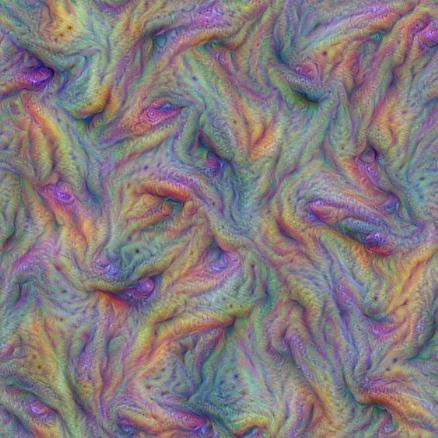

In [2]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visfunc(img))

render_lapnorm(T(layer)[:,:,:,channel])

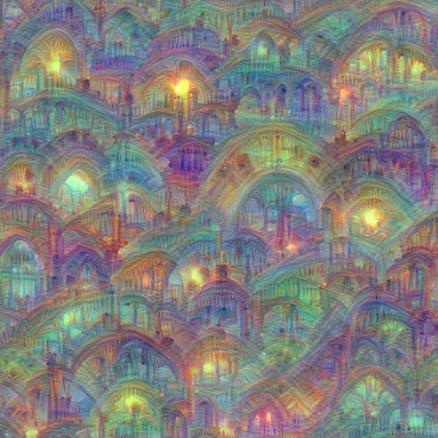

In [3]:
render_lapnorm(T(layer)[:,:,:,66])

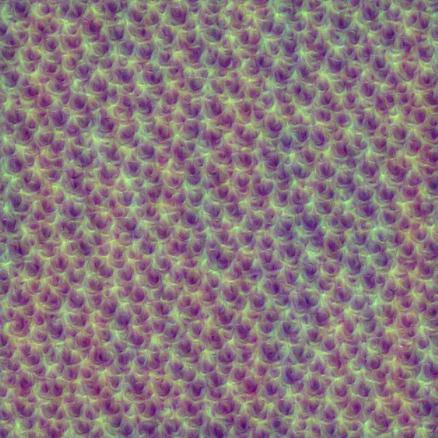

In [4]:
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,12])

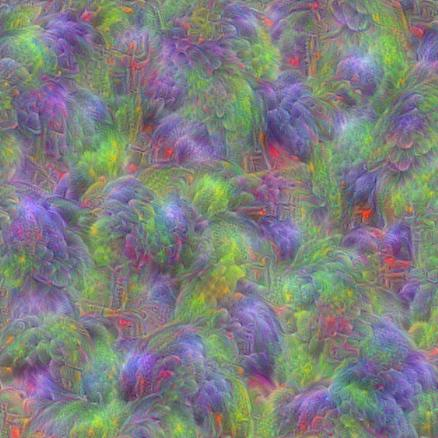

In [7]:
render_lapnorm(T(layer)[:,:,:,42] + T(layer)[:,:,:,101], octave_n=3)